In [12]:
import pandas as pd
import numpy as np
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model,Sequential
import math
import matplotlib.pyplot as plt
from datetime import datetime

# Definition of LSTM_Autoencoder(RepeatVector)

In [13]:
class LSTM_Autoencoder_RepeatVector:

    def __init__(self, dataset, timesteps, latent_dim, n_epoch,n_batch):
        self.dataset = dataset
        self.timesteps = timesteps
        self.latent_dim = latent_dim 
        self.n_batch = n_batch
        self.n_epoch = n_epoch

    def reshape(self,data):
        sample_num = math.floor(data.shape[0]/self.timesteps)
        new_dataset = np.reshape(data[:sample_num*self.timesteps],(sample_num,self.timesteps,data.shape[1]))
        return new_dataset

    def lstm_autoencoder_repeatvector(self,optimizer='adadelta',loss='mse'):
        input_dim = self.dataset.shape[1]
        inputs = Input(shape=(self.timesteps,input_dim))
        encoded = LSTM(self.latent_dim)(inputs)
        decoded = RepeatVector(self.timesteps)(encoded)
        decoded = LSTM(input_dim,return_sequences=True)(decoded)
        autoencoder = Model(inputs,decoded)
        encoder = Model(inputs,encoded)
        autoencoder.compile(optimizer=optimizer,loss=loss)

        reversed_dataset = np.empty([0,self.dataset.shape[-1]])
        for i in range(int(self.dataset.shape[0]/self.timesteps)):
            temp = self.dataset[i*self.timesteps:i*self.timesteps+self.timesteps,:]
            temp = temp[::-1,:]
            reversed_dataset = np.concatenate((reversed_dataset,temp))
        new_dataset = self.reshape(self.dataset)
        reversed_dataset = self.reshape(reversed_dataset)
        print("Trianing LSTM-Autoencoder...")
        dt1 = datetime.now()
        history = autoencoder.fit(new_dataset,reversed_dataset,
                    epochs=self.n_epoch,
                    batch_size=self.n_batch,
                    validation_split=0.33
                    )
        dt2 = datetime.now()
        print("time used of trianing LSTM-Autoencoder: ",(dt2-dt1),"s")
        print("Encoding dataset")
        dt3 = datetime.now()
        encoded_dataset = encoder.predict(new_dataset)
        dt4 = datetime.now()
        print("time used of encoding dataset ",(dt2-dt1),"s")

        
        # plot the performance of training
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
        
        # get decoder output
        decoder_output = autoencoder.predict(new_dataset)
        
        return encoded_dataset, decoder_output

# Load (10%)KDD99 dataset (only numeric features)

In [3]:
with open("C:/Users/Bin/Documents/Datasets/KDD99/columns.txt") as col_file:
    line = col_file.readline()

columns = line.split('.')
col_names = []
col_types = []
for col in columns:
    col_names.append(col.split(': ')[0].strip())
    col_types.append(col.split(': ')[1])
col_names.append("label")

df = pd.read_csv("C:/Users/Bin/Documents/Datasets/KDD99/kddcup.data_10_percent_corrected",names=col_names)

data = df.iloc[:,np.array(pd.Series(col_types)=="continuous")].as_matrix()
label = df.iloc[:,-1]

# Scaling dataset to [0,1]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
dataset = scaler.transform(data)
del data

In [5]:
dataset.shape

(494021, 34)

# Updata: Load power demand dataset

In [14]:
%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("power_demand")
datasets = ld.read()
[training_normal, validation_1, validation_2, test_normal, validation_anomaly, test_anomaly,whole_normal,whole_anormaly] = datasets
dataset = np.reshape(whole_normal,(-1,1))

C:\Users\Bin\Desktop\Thesis\code\Loaddata.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sub_power = sub_power.reshape(-1, 1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Trianing LSTM-Autoencoder...
Train on 30 samples, validate on 15 samples
Epoch 1/50
30/30 [==============================] - 4s 120ms/step - loss: 0.1461 - val_loss: 0.1413
Epoch 2/50
30/30 [==============================] - 1s 34ms/step - loss: 0.1057 - val_loss: 0.1017
Epoch 3/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0711 - val_loss: 0.0661
Epoch 4/50
30/30 [==============================] - 1s 34ms/step - loss: 0.0459 - val_loss: 0.0478
Epoch 5/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0384 - val_loss: 0.0449
Epoch 6/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0378 - val_loss: 0.0446
Epoch 7/50
30/30 [==============================] - 1s 33ms/step - loss: 0.0377 - val_loss: 0.0443
Epoch 8/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0376 - val_loss: 0.0445
Epoch 9/50
30/30 [==============================] - 1s 34ms/step - loss: 0.0375 - val_loss: 0.0441
Epoch 10/50
30/30 [================

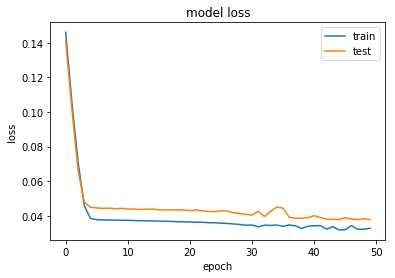

In [15]:
# power demand training
timesteps = 84
latent_dim = 40
n_epoch = 50
n_batch = 3
model = LSTM_Autoencoder_RepeatVector(dataset,timesteps,latent_dim,n_epoch,n_batch)
encoded_dataset,output = model.lstm_autoencoder_repeatvector()

# Train the Autoencoder 

In [ ]:
# KDD99 training
timesteps = 10
latent_dim = 10
n_epoch = 100
n_batch = 100

model = LSTM_Autoencoder_RepeatVector(dataset,timesteps,latent_dim,n_epoch,n_batch)
encoded_dataset = model.lstm_autoencoder_repeatvector()
# generate labels for encoded_dataset
e_label = [None]*encoded_dataset.shape[0]
for i in range(encoded_dataset.shape[0]):
    e_label[i] = label[(i+1)*timesteps-1] # for each batch, use the last sample label as the encoded batch label
e_label = np.array(e_label)

In [ ]:
#Todo
#inverse scaling

# Two SVM classifier for original dataset and encoded dataset

In [115]:
# prepare both original and encoded data

def train_test_split(dataset,label):
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    y_train, y_test = label[0:train_size],label[train_size:len(dataset)]
    # label str2int
    with open("C:/Users/Bin/Documents/Datasets/KDD99/classes.txt") as f:
        line = f.readline()
    classes = line.split(",")
    class_dic = {classes[i]:i for i in range(len(classes))}
    y_train_num = [class_dic[x.strip('.')] for x in y_train]
    y_test_num = [class_dic[x.strip('.')] for x in y_test]
    return train,test,y_train_num,y_test_num
xn_train, xn_test, yn_train,yn_test =  train_test_split(dataset,label)
xe_train, xe_test, ye_train,ye_test =  train_test_split(encoded_dataset,e_label)


In [116]:
# train two svm classifiers
from sklearn import svm

print("Trianing SVM classifier with original dataset...")
dt1 = datetime.now()
clf_n = svm.SVC()
clf_n.fit(xn_train,yn_train)
dt2 = datetime.now()
print("time used of trianing on original dataset: ",(dt2-dt1),"s")
print("Trianing SVM classifier with encoded dataset...")
dt3 = datetime.now()
clf_e = svm.SVC()
clf_e.fit(xe_train,ye_train)
dt4 = datetime.now()
print("time used of training on encoded dataset: ",(dt4-dt3),"s")

Trianing SVM classifier with original dataset...
time used of trianing on original dataset:  0:01:05.823061 s
Trianing SVM classifier with encoded dataset...
time used of training on encoded dataset:  0:00:00.118958 s


In [117]:
# making prediction using both classifier and both dataset

#original
print("Making prediction using original dataset...")
dt1 = datetime.now()
prediction_n = clf_n.predict(xn_test)
dt2 = datetime.now()
print("time used of prediction using original dataset: ",(dt2-dt1),"s")
#encoded
print("Making prediction using encoded dataset...")
dt3 = datetime.now()
prediction_e = clf_e.predict(xe_test)
dt4 = datetime.now()
print("time used of prediction using encoded dataset: ",(dt4-dt3),"s")

Making prediction using original dataset...
time used of prediction using original dataset:  0:01:34.830185 s
Making prediction using encoded dataset...
time used of prediction using encoded dataset:  0:00:00.084652 s


# Performance comparation

In [124]:
#Evaluation
from sklearn.metrics import classification_report
# performance using original dataset
print("Performance on original dataset\n")
print(classification_report(yn_test, prediction_n,digits=5))


Performance on original dataset

             precision    recall  f1-score   support

          0    0.00000   0.00000   0.00000       100
          1    0.00000   0.00000   0.00000        18
          3    0.00000   0.00000   0.00000         0
          5    0.55000   0.14286   0.22680       385
          6    0.50000   0.25000   0.33333         4
          7    0.00000   0.00000   0.00000         1
          9    0.99982   0.69034   0.81675     66079
         10    0.00000   0.00000   0.00000         0
         11    0.98389   0.97064   0.97722     26053
         12    0.00000   0.00000   0.00000         1
         13    0.00000   0.00000   0.00000         1
         14    0.00000   0.00000   0.00000       162
         15    0.01682   0.87282   0.03301       401
         16    0.00000   0.00000   0.00000         3
         17    0.00000   0.00000   0.00000         2
         18    0.99952   0.99908   0.99930     69235
         20    1.00000   0.99141   0.99569       582
         21 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [125]:
# Performance using encoded dataset
print("Performance on encoded dataset\n")
print(classification_report(ye_test, prediction_e,digits=5))

Performance on encoded dataset

             precision    recall  f1-score   support

          0    0.00000   0.00000   0.00000         3
          5    0.00000   0.00000   0.00000        17
          9    0.99868   0.68875   0.81525      2204
         11    0.93900   0.99538   0.96637       866
         14    0.00000   0.00000   0.00000         4
         15    1.00000   0.53846   0.70000        13
         17    0.00000   0.00000   0.00000         0
         18    0.99913   0.99783   0.99848      2308
         20    0.00000   0.00000   0.00000        20

avg / total    0.98128   0.86293   0.91026      5435



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [123]:
encoded_dataset.shape

(16467, 10)